In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

https://otexts.com/fpp2/non-seasonal-arima.html

https://hands-on.cloud/using-the-arima-model-and-python-for-time-series-forecasting/ --> best one

# Load Dataset

---

In [2]:
final = pd.read_csv('final_dataset.csv', parse_dates = ['datetime'], 
                    index_col = ['datetime'])
final.head()
#final1 = final.loc[:, final.columns != 'season']

,generation biomass,generation hydro water reservoir,generation other renewable,generation solar,generation waste,generation wind onshore,price day ahead,price actual,temp,pressure,...,rain_1h,rain_3h,snow_3h,clouds_all,year,month,day,hour,generation fossil,season
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,447.0,1899.0,73.0,49.0,196.0,6378.0,50.10,65.41,267.325,971,...,0.0,0.0,0.0,0,2015,1,1,0,10156.0,winter
2015-01-01 01:00:00,449.0,1658.0,71.0,50.0,195.0,5890.0,48.10,64.92,267.325,971,...,0.0,0.0,0.0,0,2015,1,1,1,10437.0,winter
2015-01-01 02:00:00,448.0,1371.0,73.0,50.0,196.0,5461.0,47.33,64.48,266.186,971,...,0.0,0.0,0.0,0,2015,1,1,2,9918.0,winter
2015-01-01 03:00:00,438.0,779.0,75.0,50.0,191.0,5238.0,42.27,59.32,266.186,971,...,0.0,0.0,0.0,0,2015,1,1,3,8859.0,winter
2015-01-01 04:00:00,428.0,720.0,74.0,42.0,189.0,4935.0,38.41,56.04,266.186,971,...,0.0,0.0,0.0,0,2015,1,1,4,8313.0,winter


<AxesSubplot:xlabel='datetime'>

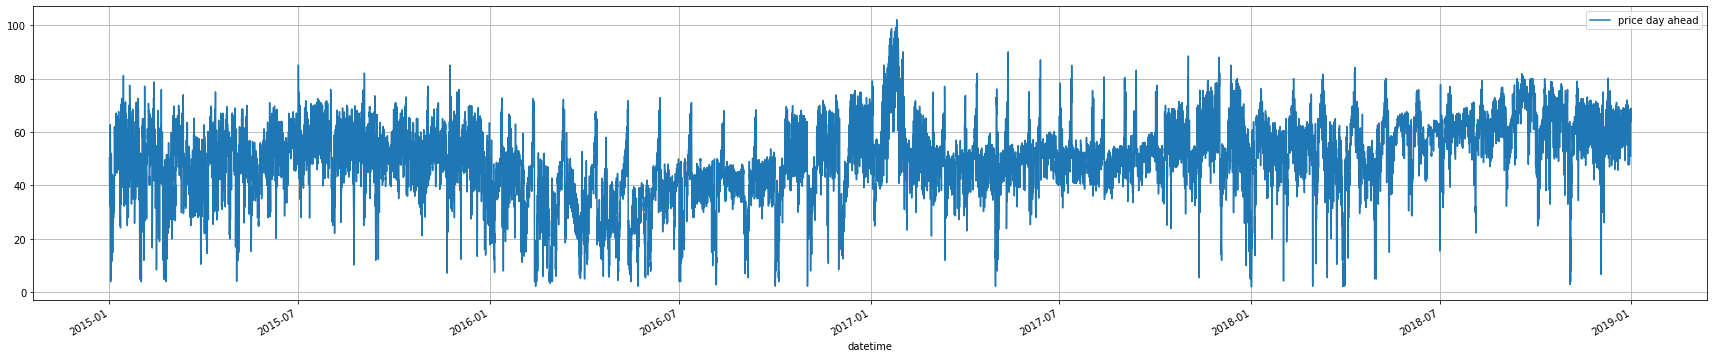

In [3]:
final.plot(y=['price day ahead'], figsize=(30, 6), grid=True)

In order to build an Time Series Forecasting model such as ARIMA, we need to make sure the time series is stationary with the Augmented Dickey-Fuller Test -> Time series is stationary if the p-value is low and the critical values at 1%, 5%, 10%, confidence intervals are as close as possible to the ADF statistics.

In [128]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(final['price actual'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.142403
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Here we can see that the p-value is 0.0000 which lower than all of the significance levels. Thus, we will reject the null hypothesis in each case and conclude that the data is not stationary and requires differentiation.

By doing the differenation we will also find our 3 parameters for the ARIMA model that are p, d and q where:

    p is the order of the AR term 
            (# of lags of Y to be utilized as predictors) is quite significant
    q is the order of the MA term
            (# of lagged forecast errors should be used)
    d is the number of differences required to make the time series stationary




## Differentation

### d parameter

There is no such method that can tell us how much value of d will be optimal. However, the value of differencing can be optimal till 2 so we will try our time series in both. Pandas provide this option of differencing. Let’s utilize this.

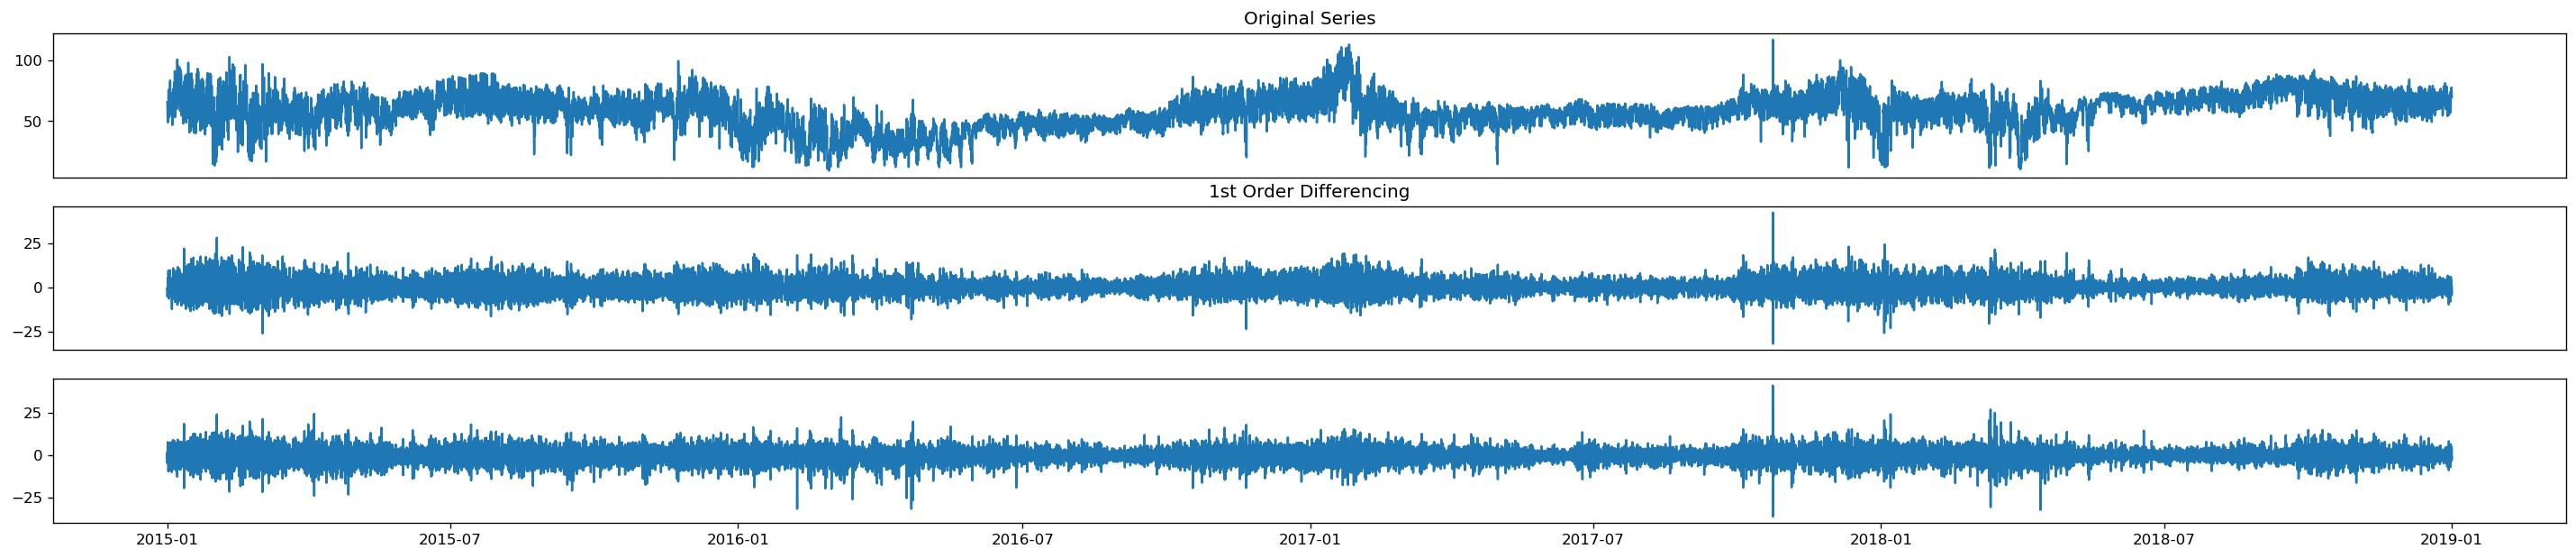

In [148]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(30,6), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(final['price actual']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(final['price actual'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(final['price actual'].diff().diff());
plt.show()

As we can see the time series has become stationary. We can see that there is not much difference between the 1st and 2nd order. Therefore, we can select 1st order differencing for our model. d = 1

### p parameter

We are going to find the optimal value of p which is our number of autoregressive terms. We can find this value by inspecting the PACF plot.

The partial autocorrelation function plot can be used to draw a correlation between the time series and its lag while the contribution from intermediate lags can be ignored. This plotting will let us know about the lags that are not required in the autoregression part.

Significant correlation in a stationary time series can be represented by adding auto regression terms. Using the PACF plot we can take the order of AR terms to be equal to the lags that can cross a significance limit.

C:\Users\halim\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


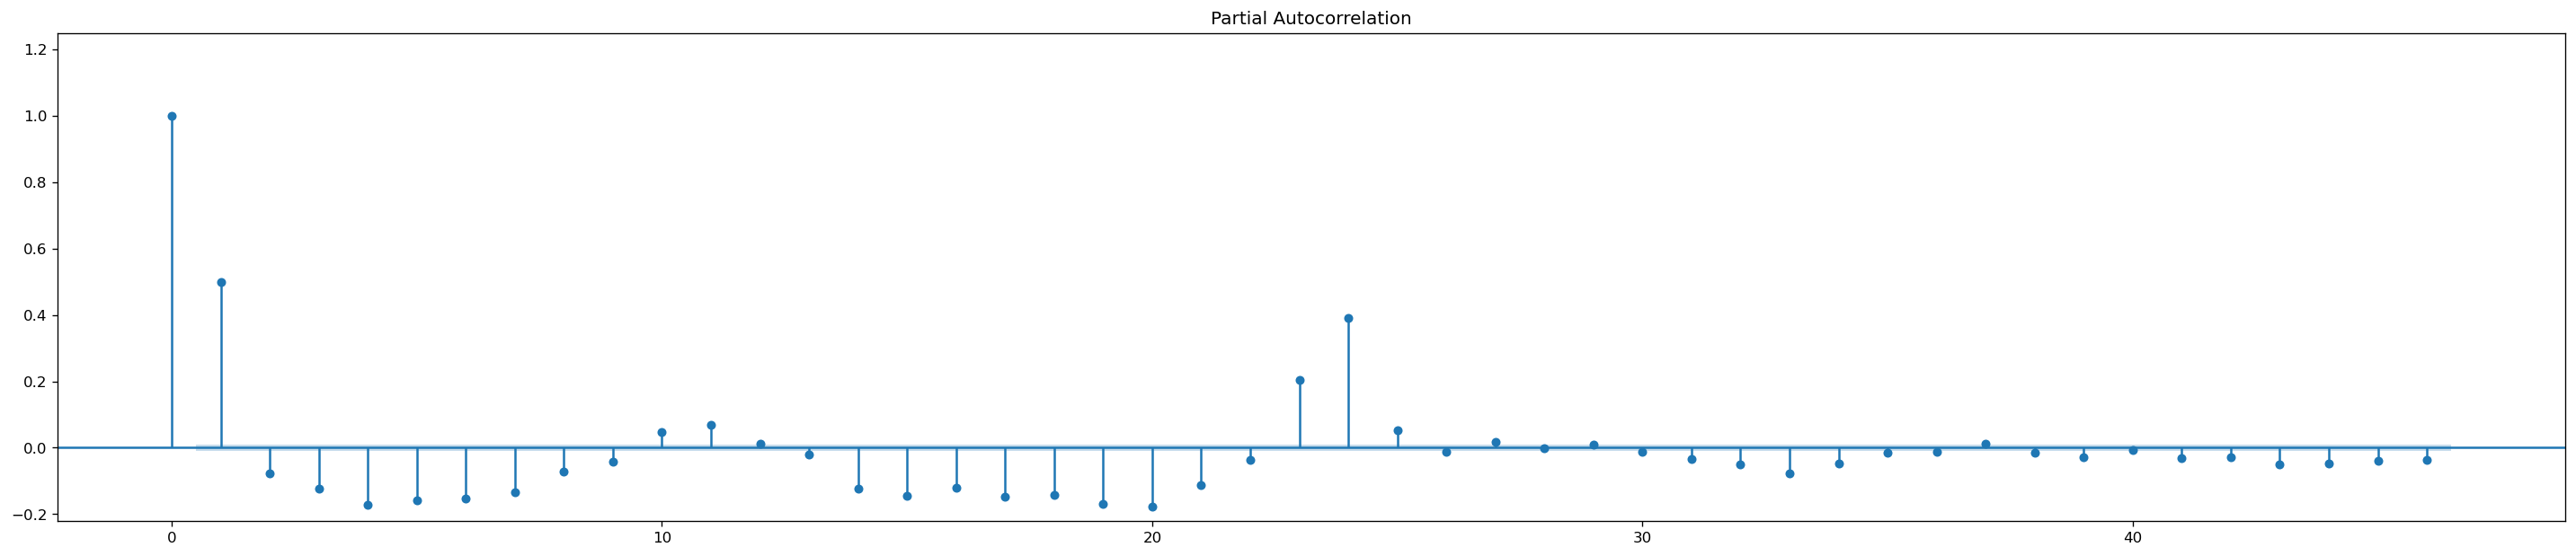

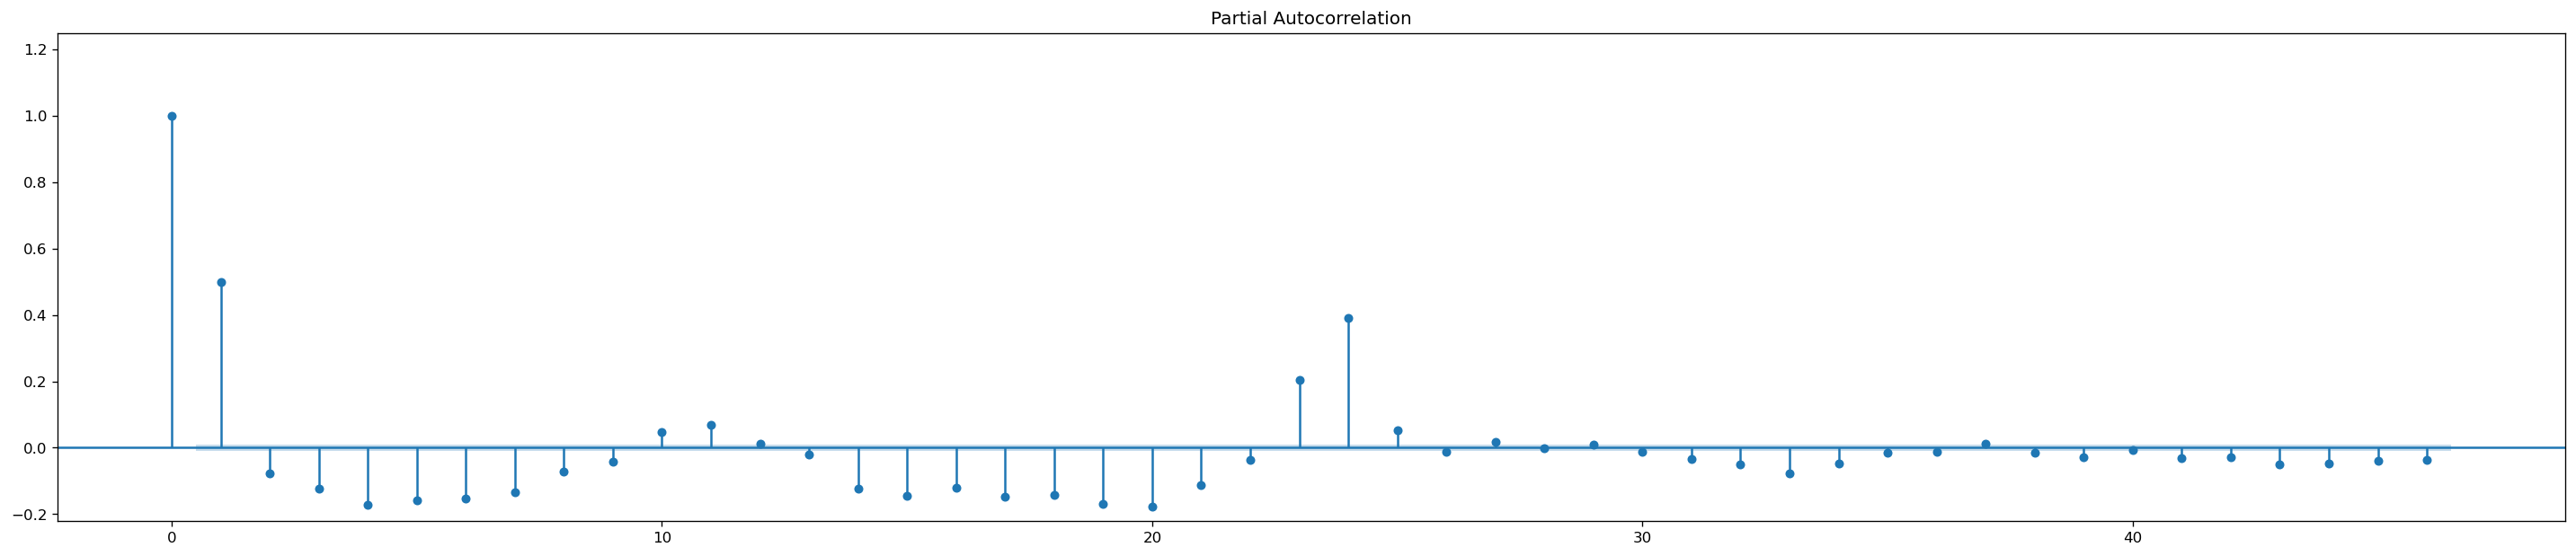

In [161]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(30,6))
plot_pacf(final['price actual'].diff().dropna(), ax=ax, auto_ylims=True)

As we can we see there a lot of significant autocorrelation up until a big spike at lag=24. For now, let's decide that p=24 then.

### q parameter

In order to find the value of q we can use the ACF plot which tell us how much moving average is requiered to remove the autocorrelation from the stationary time series.

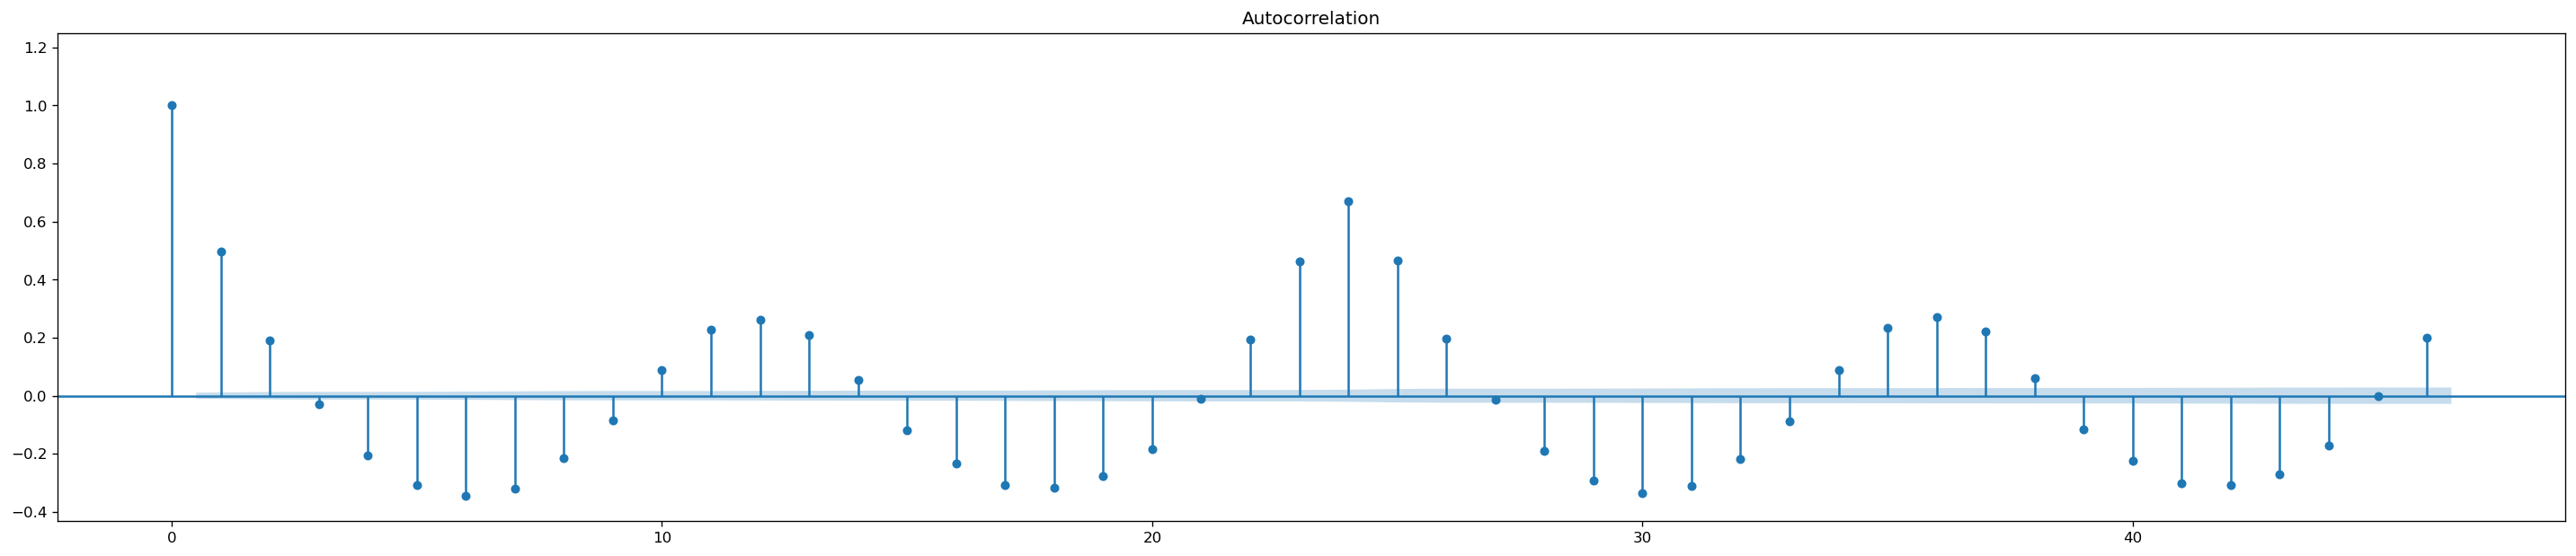

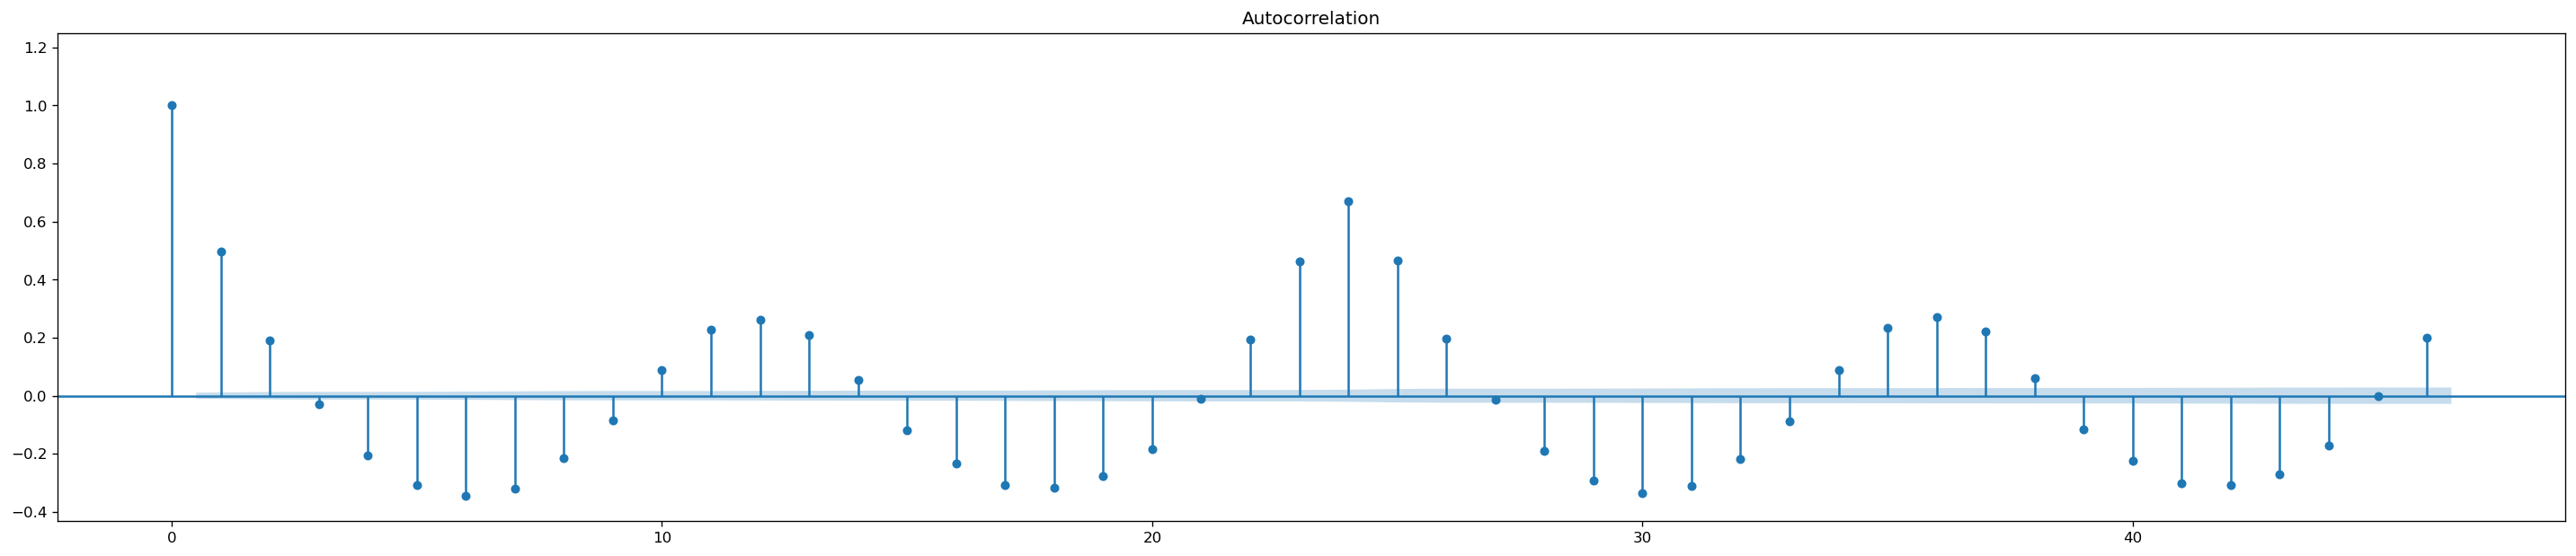

In [163]:
fig, ax = plt.subplots(figsize=(30,6))
plot_acf(final['price actual'].diff().dropna(), ax=ax, auto_ylims=True)

We can also see the ACF plot is sinuolidal so we can assume that d = 0 as the data may follow an ARIMA(p,d,0) model if the ACF and PACF plots of the differenced data show the following patterns:
    
    the ACF is exponentially decaying or sinusoidal;
    there is a significant spike at lag p in the PACF, but none beyond lag p.

## Building the ARIMA model

In [168]:
from statsmodels.tsa.arima.model  import ARIMA

model = ARIMA(final['price actual'], order = (24,1,0))
model_fit = model.fit()
model_fit
model_fit.summary()

C:\Users\halim\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\halim\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\halim\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           price actual   No. Observations:                35060
Model:                ARIMA(24, 1, 0)   Log Likelihood              -81273.895
Date:                Sat, 26 Nov 2022   AIC                         162597.789
Time:                        21:35:09   BIC                         162809.409
Sample:                             0   HQIC                        162665.190
                              - 35060                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1916      0.003     56.710      0.000       0.185       0.198
ar.L2         -0.0628      0.004    -15.958      0.000      -0.071      -0.055
ar.L3         -0.0518      0.004    -11.979      0.000      -0.060      -0.043
ar.L4         -0.0725      0.004    -19.256      0.000      -0.080      -0.065
ar.L5         -0.0797      0.004    -18.948      0.000      -0.088      -0.071
ar.L6         -0.0790      0.004    -19.388      0.000      -0.087      -0.071
ar.L7         -0.0865      0.004    -20.798      0.000      -0.095      -0.078
ar.L8         -0.0525      0.005    -11.548      0.000      -0.061      -0.044
ar.L9         -0.0665      0.004    -14.928      0.000      -0.075      -0.058
ar.L10        -0.0395      0.005     -8.527      0.000      -0.049      -0.030
ar.L11        -0.0211      0.004     -4.835      0.000      -0.030      -0.013
ar.L12        -0.0467      0.004    -11.085      0.000      -0.055      -0.038
ar.L13        -0.0306      0.004     -7.220      0.000      -0.039      -0.022
ar.L14        -0.0766      0.005    -16.733      0.000      -0.086      -0.068
ar.L15        -0.0914      0.005    -19.453      0.000      -0.101      -0.082
ar.L16        -0.0582      0.005    -12.774      0.000      -0.067      -0.049
ar.L17        -0.0599      0.005    -13.220      0.000      -0.069      -0.051
ar.L18        -0.0430      0.004     -9.964      0.000      -0.052      -0.035
ar.L19        -0.0519      0.004    -11.681      0.000      -0.061      -0.043
ar.L20        -0.0778      0.004    -17.366      0.000      -0.087      -0.069
ar.L21        -0.0458      0.005    -10.138      0.000      -0.055      -0.037
ar.L22        -0.0529      0.004    -11.995      0.000      -0.062      -0.044
ar.L23         0.0985      0.004     24.937      0.000       0.091       0.106
ar.L24         0.3921      0.003    118.439      0.000       0.386       0.399
sigma2         6.0392      0.023    264.524      0.000       5.994       6.084
===================================================================================
Ljung-Box (L1) (Q):                  14.28   Jarque-Bera (JB):             80030.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Here we can see the summary of the model

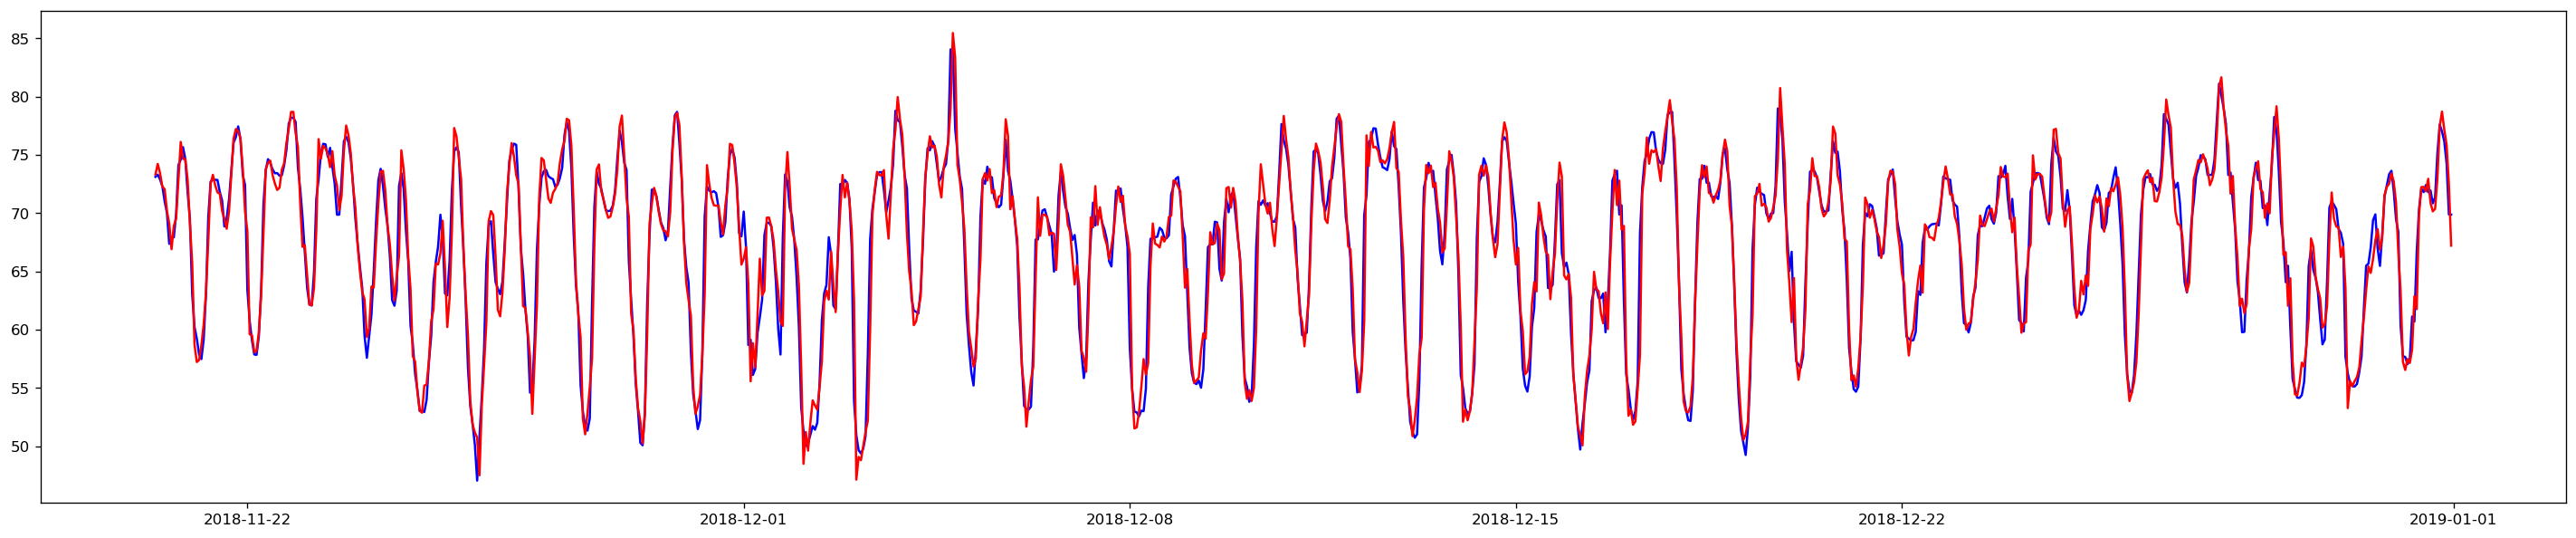

In [289]:
final['forecast'] = model_fit.predict(dynamic=False)

#plt.figure(figsize=(30,6))
plt.plot(final['price actual'][-1000:], color ='blue',label='Price Actual')
plt.plot(final['forecast'][-1000:], color ='red',label='Forecast')

As we can see, the prediction seems to follow the trend and we seem to have a decent ARIMA model. However, we still need to predict the future !

## Predict the future

We split the dataset, we will use the feature between 2015 and 2017 to predict those in 2018

In [211]:
train = final['price actual']['2015-01-01':'2017-12-31']
test = final['price actual']['2018-01-01':]

In [301]:
def get_sarimax(forecast_interval):
    total = len(final['price actual'])
    aaa = forecast_interval 
    hist = total - aaa

    model = sm.tsa.statespace.SARIMAX(final['price actual'].values[:hist], order=(24,1,0))
    fitted = model.fit(disp=False)
    
    result = fitted.forecast(aaa, alpha =0.05)
    conf_ins = fitted.get_forecast(aaa).summary_frame()
    ind = np.arange(total)
    
    fig, ax = plt.subplots()
    ax.plot(ind[-int(aaa*3.5):], final['price actual'][-int(aaa*3.5):], label='Actual price')
    ax.plot(ind[-aaa:], result,label='Predicted price')
    ax.plot(ind[-aaa:], conf_ins['mean_ci_lower'])
    ax.plot(ind[-aaa:], conf_ins['mean_ci_upper'])
    ax.legend()
    fig.autofmt_xdate()
    plt.show()

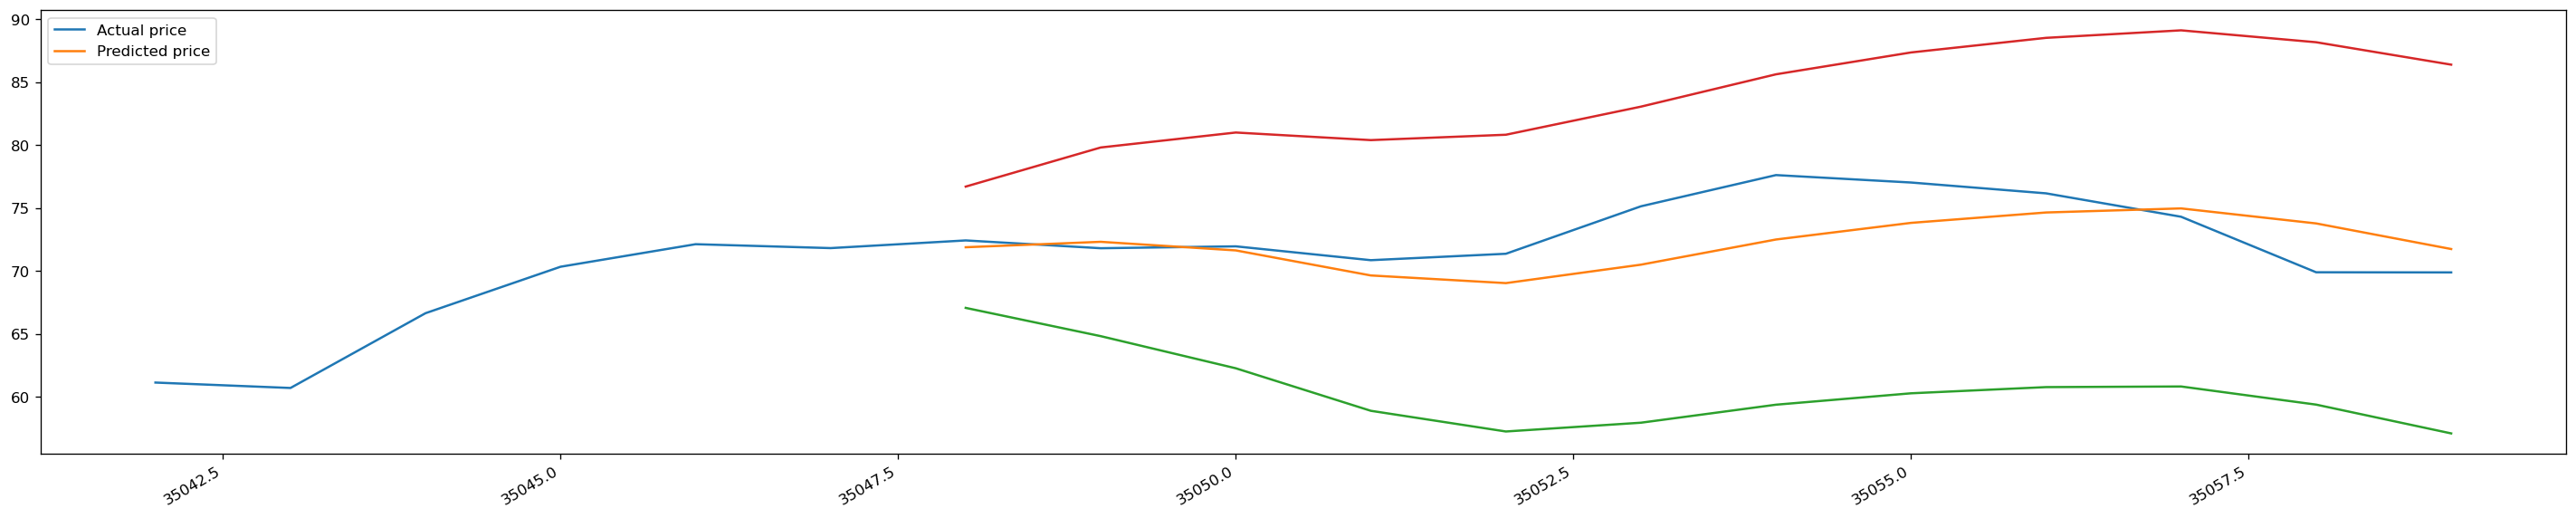

In [311]:
get_sarimax(12) # 12 hours

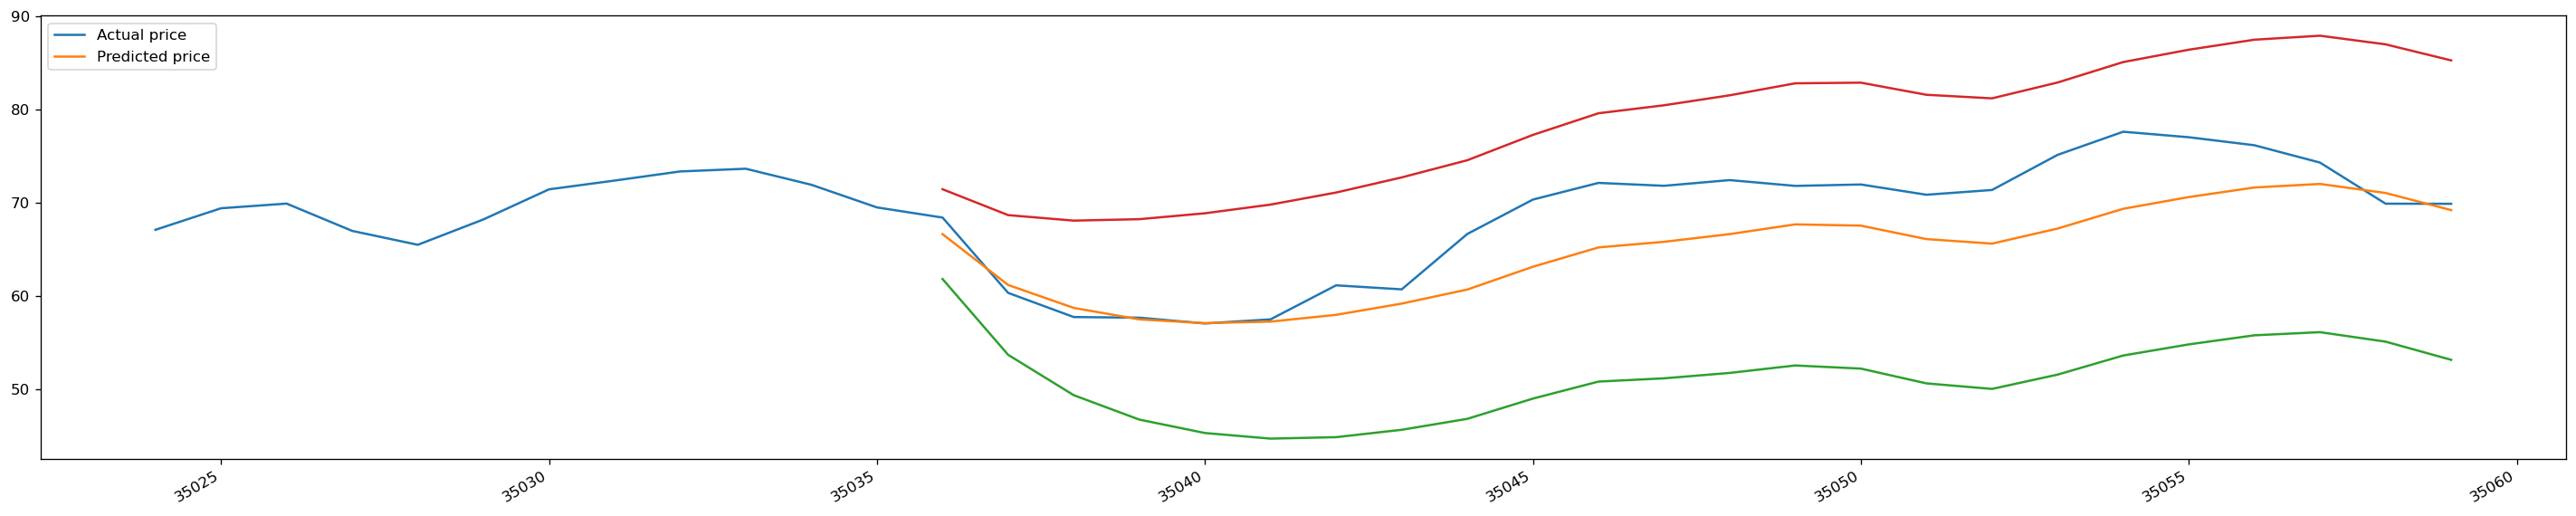

In [312]:
get_sarimax(24) #1 day

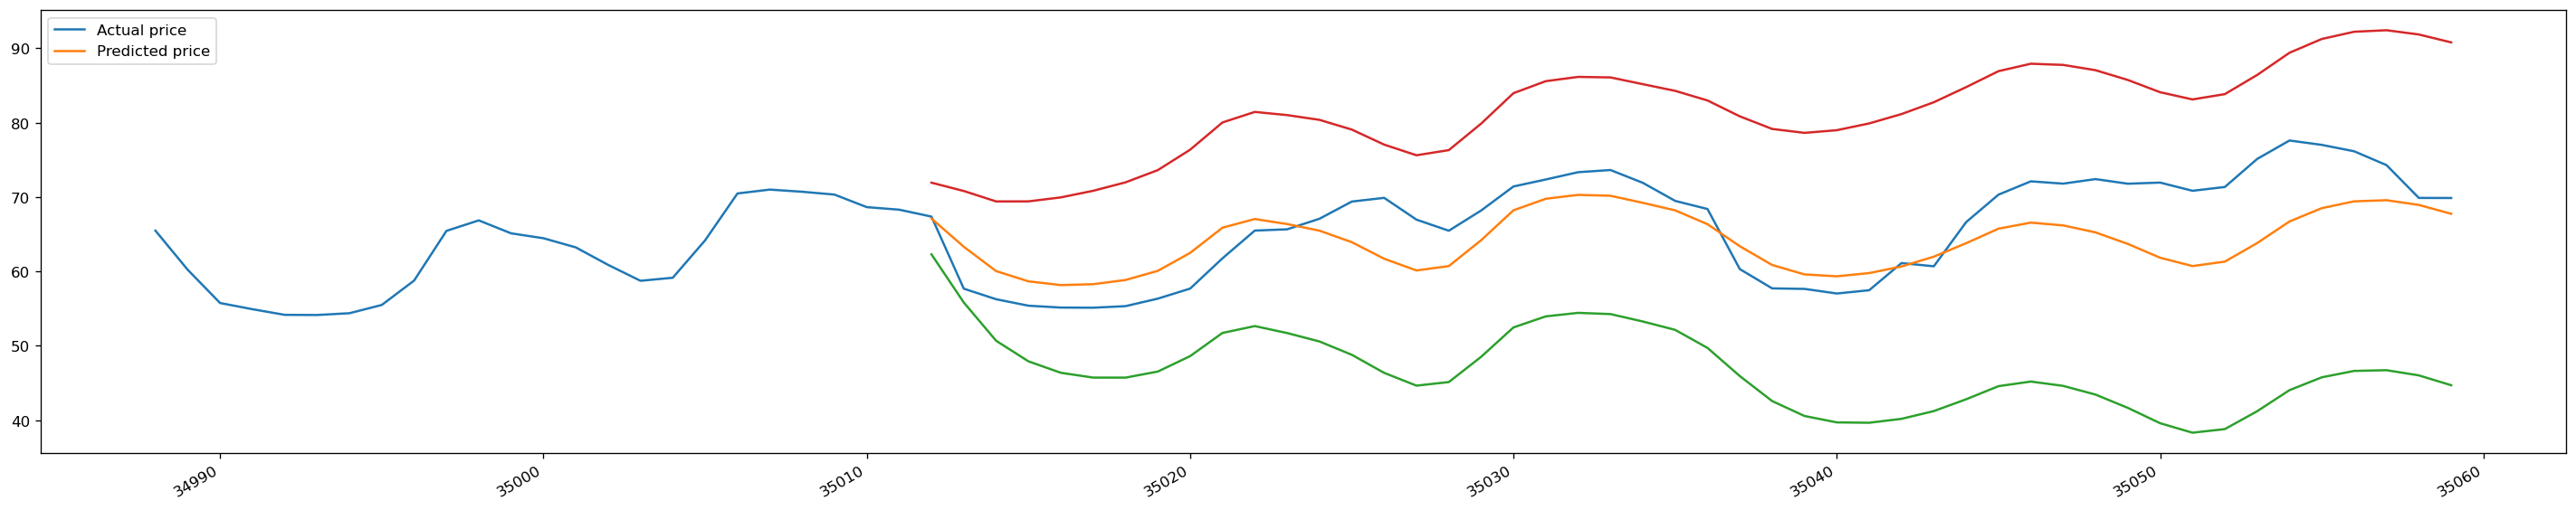

In [313]:
get_sarimax(48) #2 days

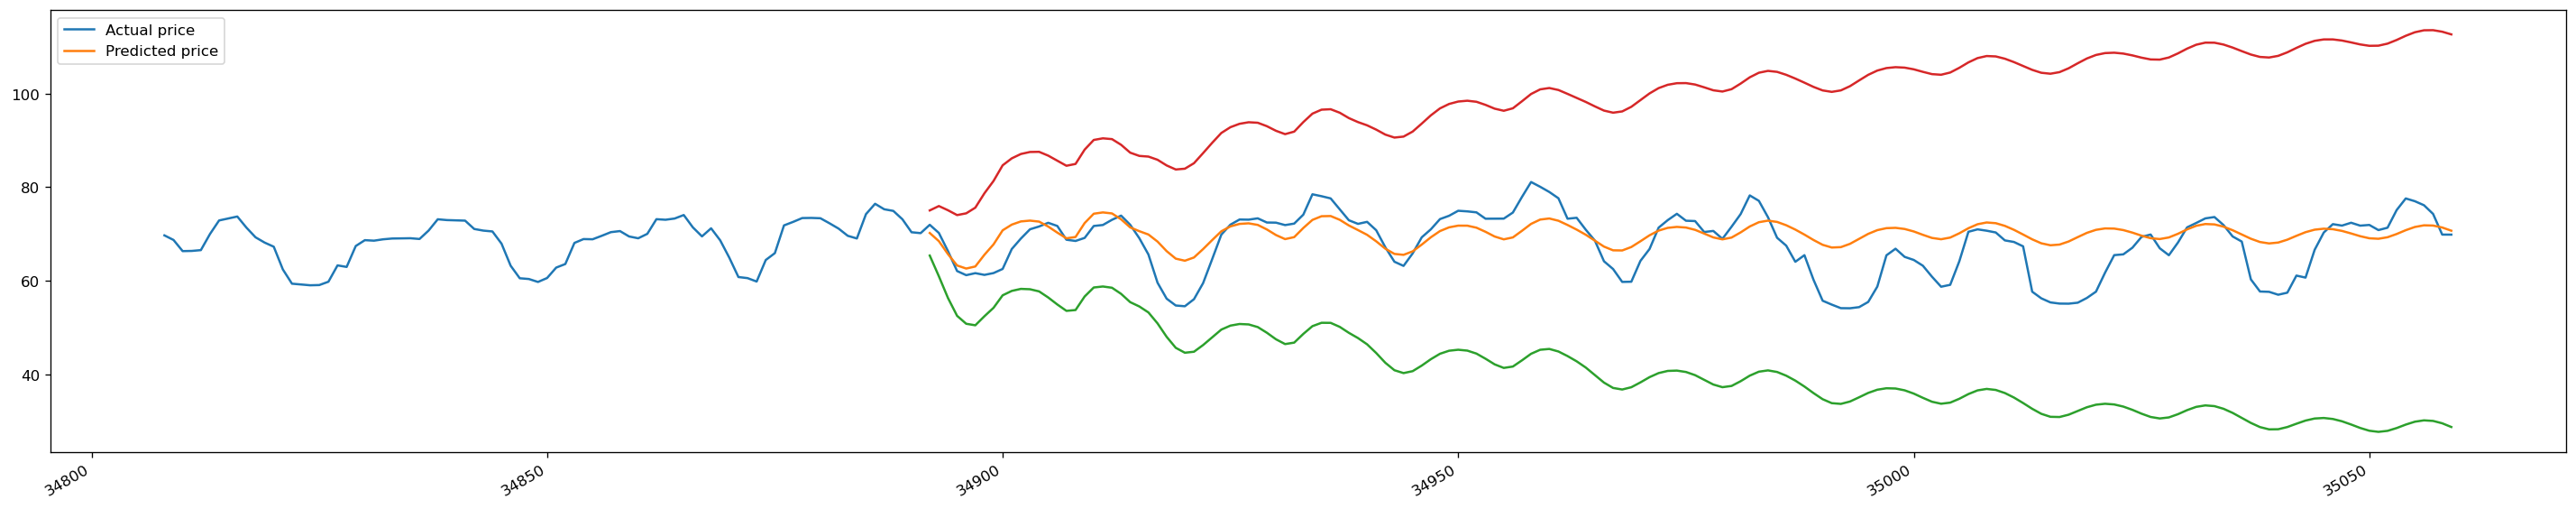

In [314]:
get_sarimax(168) #1 weak

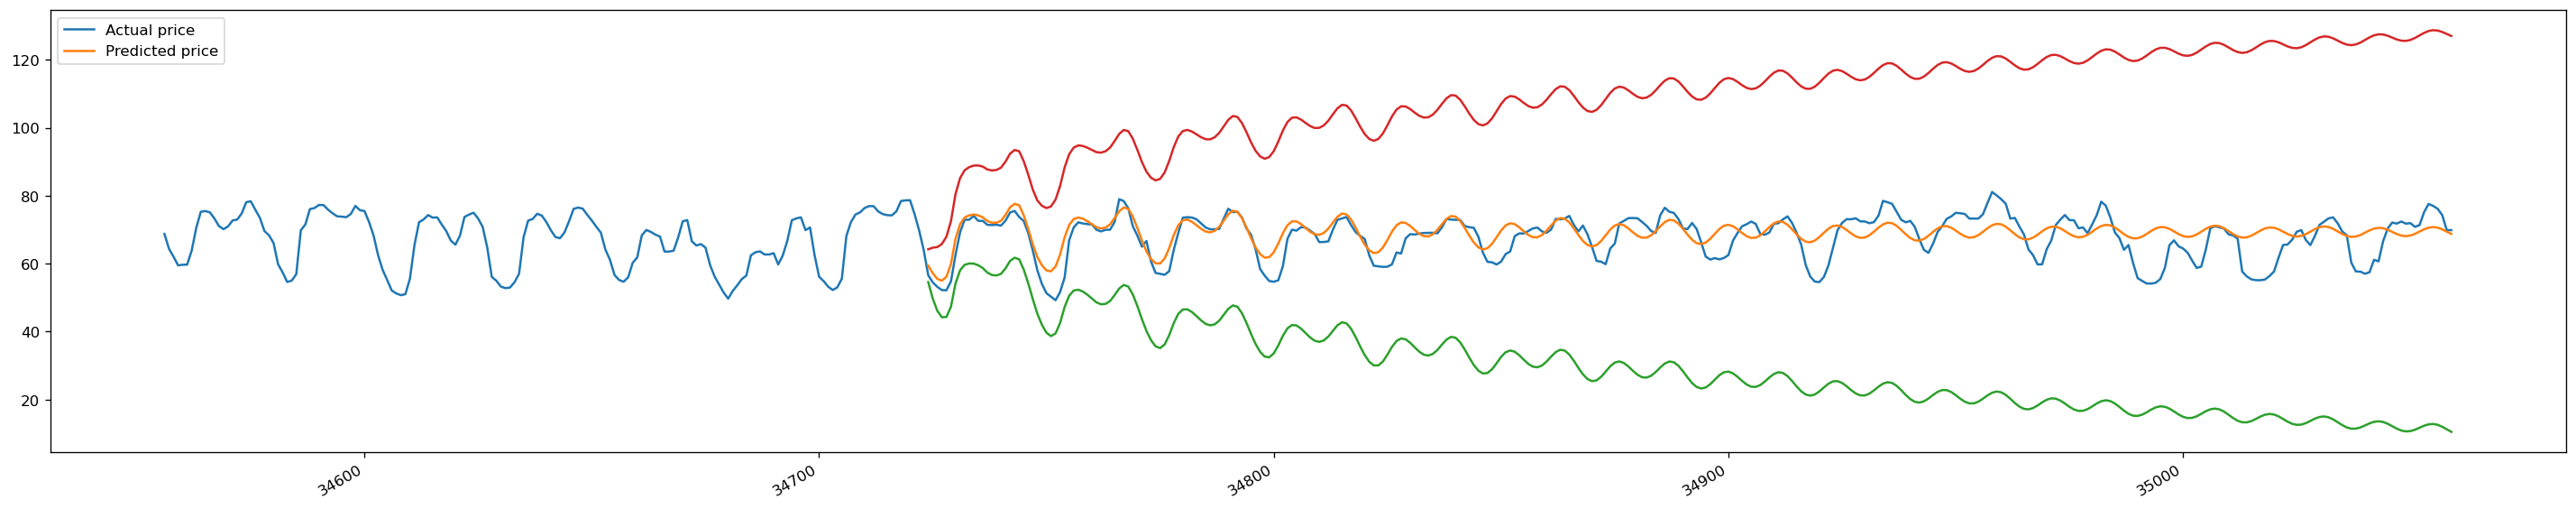

In [316]:
get_sarimax(336) #2 weaks

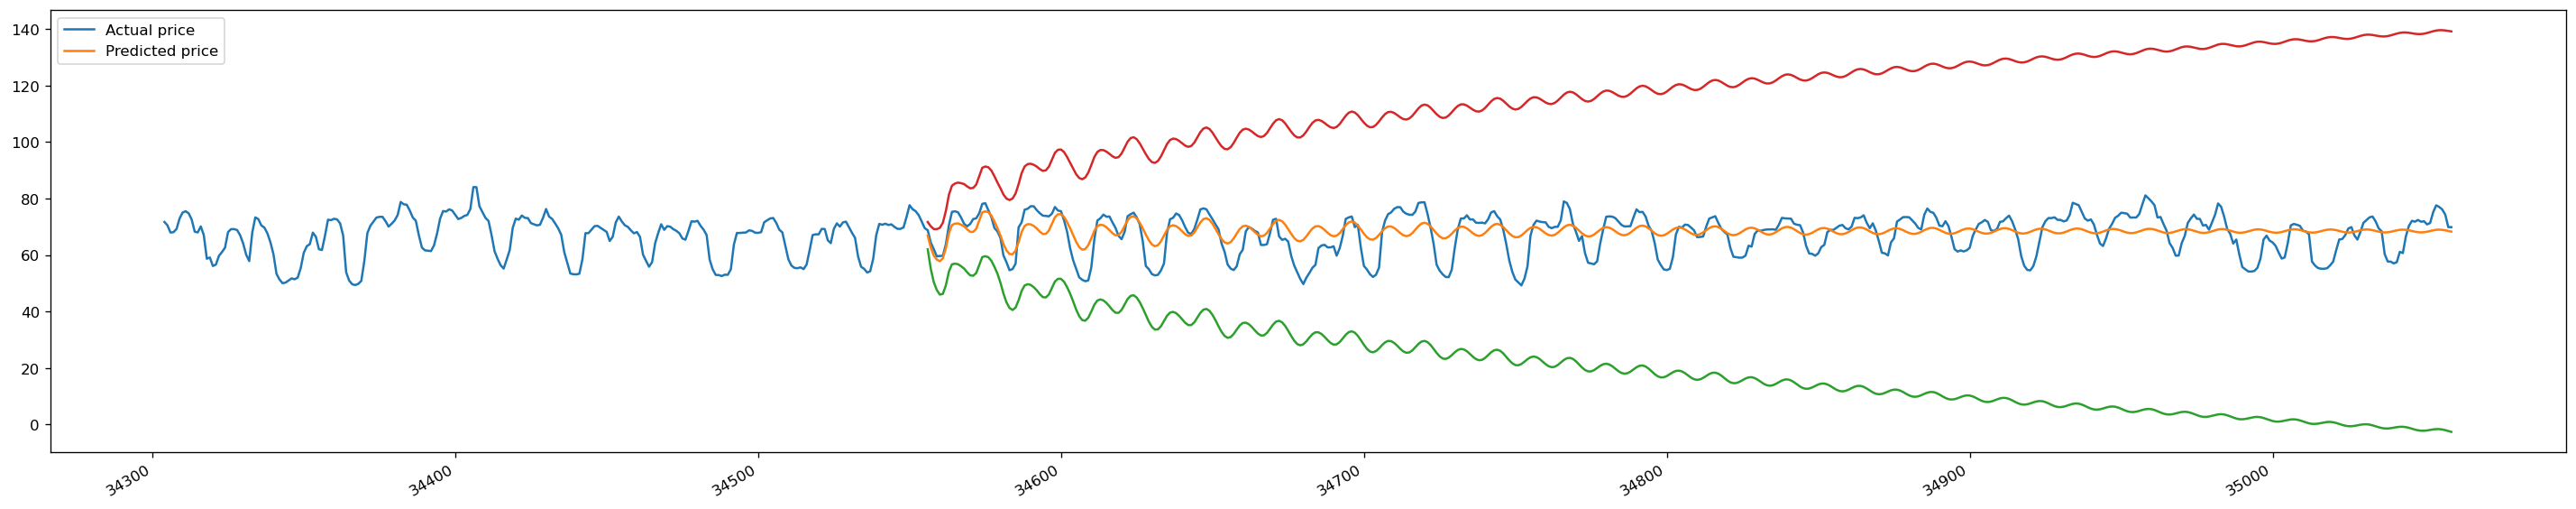

In [317]:
get_sarimax(504) #3 weaks

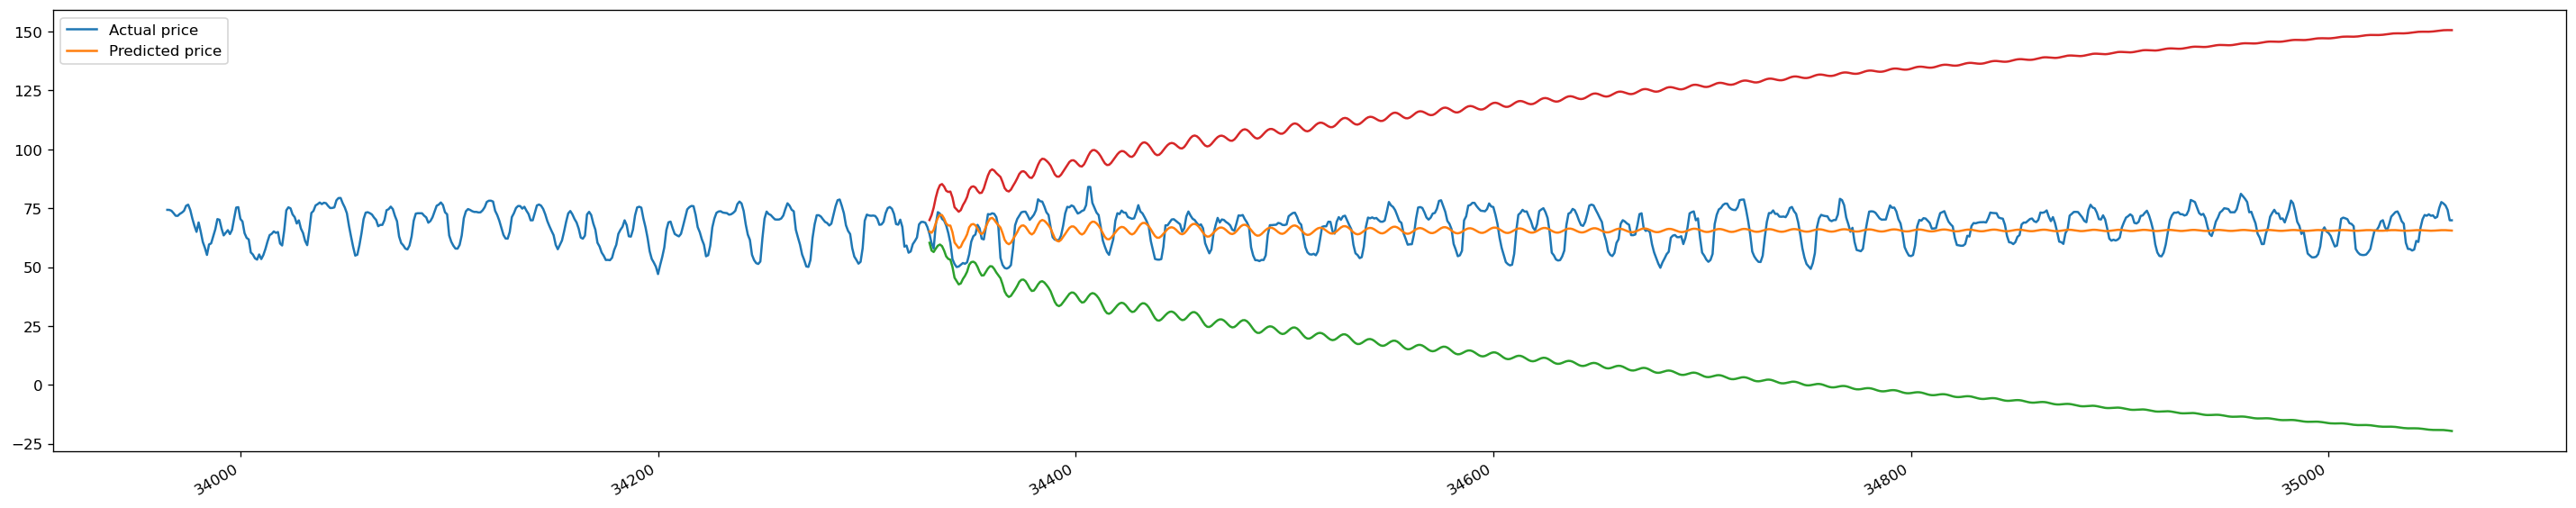

In [315]:
get_sarimax(730) #1 months

As we can see, we can currently predict quite accurately the price up to 1 and a half week (yellow line) before it starts being a straight line. 

---

## \\/ What I did before starting over (I keep it just in case)

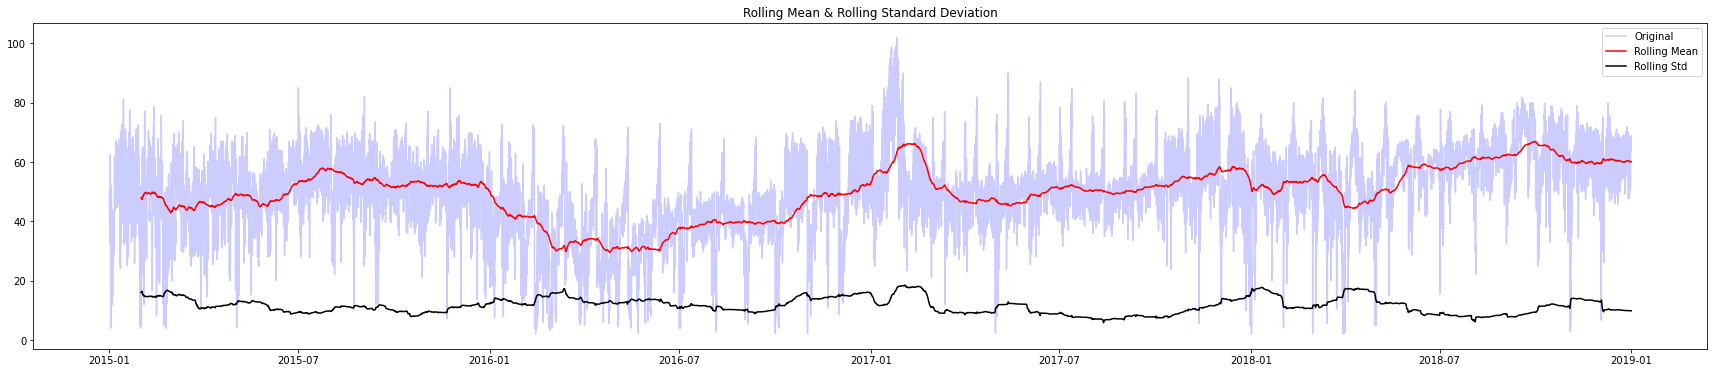

In [4]:
rolling_mean = final['price day ahead'].rolling(window = 730).mean()
rolling_std = final['price day ahead'].rolling(window = 730).std()

plt.figure(figsize=(30,6))
plt.plot(final['price day ahead'], color = 'blue', label = 'Original', alpha=0.2)
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

As we can see, the rolling mean and std are more or less constant so it is hard to decide whether the time series is stationary or not. Let's use the Augmented Dicky Fuller (ADF) test and see if we can reject the null hypothesis

*(If it's rejected -> Test statistic < Critical Value and p-value < 0.5)

In [5]:
def get_stationarity(timeseries):
    """
    Function to run the two tests which determine wether a given series is stationary.
    """
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=730).mean() #730=hours in a month
    rolling_std = timeseries.rolling(window=730).std()
    
    # rolling statistics plot
    plt.figure(figsize=(30,6))
    original = plt.plot(timeseries, color='blue', label='Original', alpha=0.2)
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

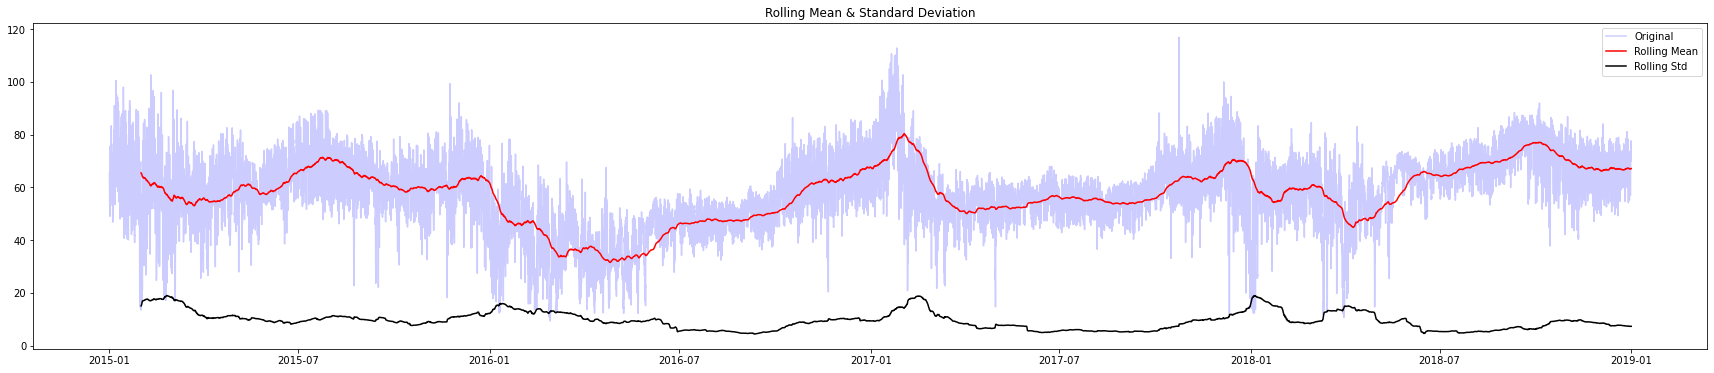

ADF Statistic: -9.142403228484993
p-value: 2.8261693147045503e-15
Critical Values:
	1%: -3.4305368028090353
	5%: -2.861622562226085
	10%: -2.5668139452779717


In [6]:
get_stationarity(final['price actual'])

p-value = 2*10^-15

critical values and p-value is < 0.05. Thus, the time series data is stationary.

### Split and Train the data

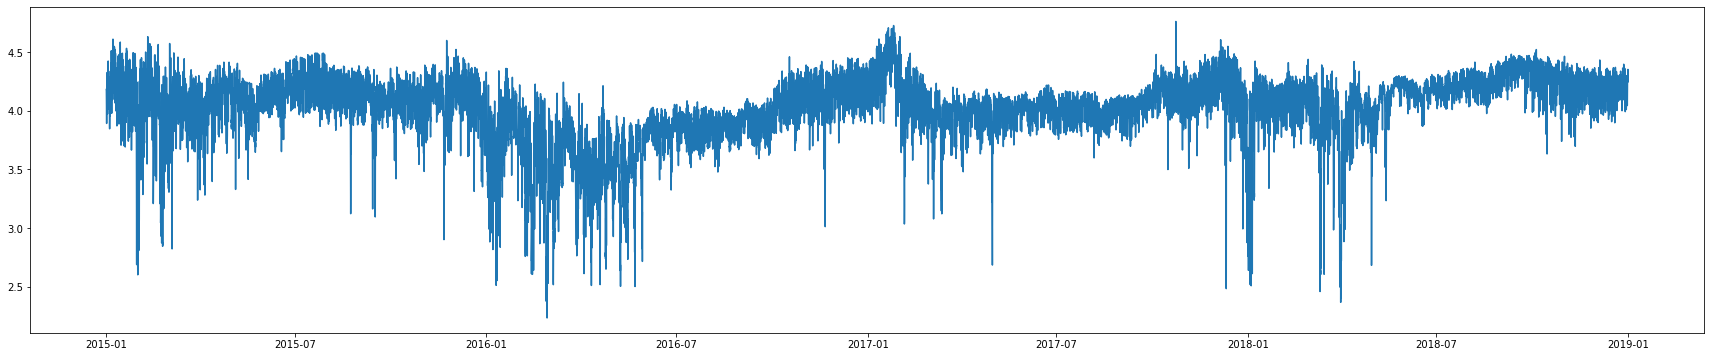

In [7]:
final_log = np.log(final['price actual'])
plt.figure(figsize=(30,6))
plt.plot(final_log)

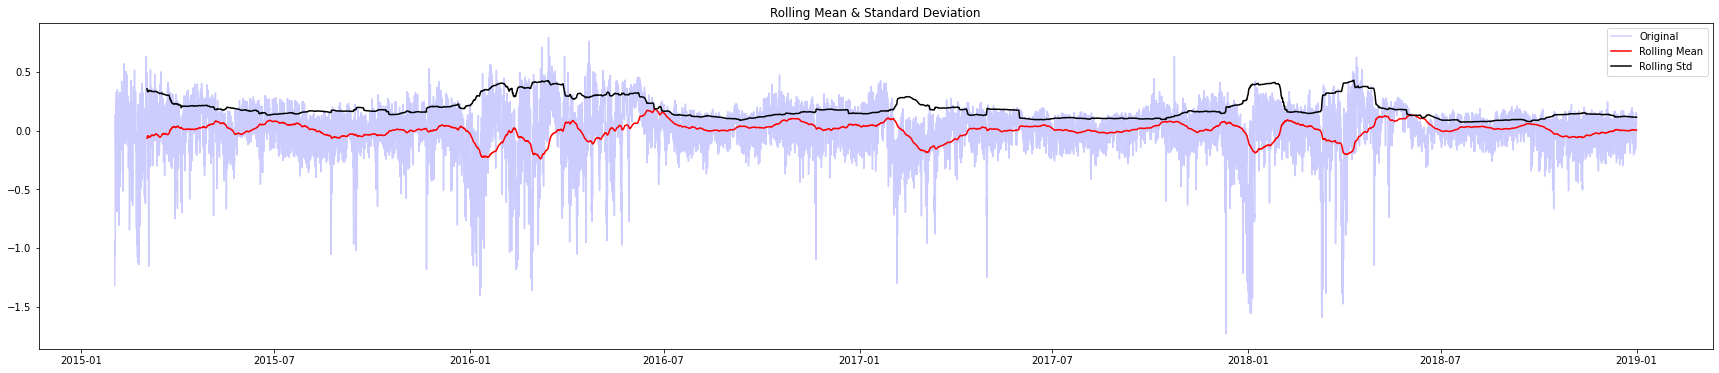

ADF Statistic: -17.27045796649211
p-value: 5.8652662033295524e-30
Critical Values:
	1%: -3.4305408926133603
	5%: -2.8616243697604156
	10%: -2.566814907381799


In [8]:
rolling_mean = final_log.rolling(window=750).mean()
final_log_minus_mean = final_log - rolling_mean
final_log_minus_mean.dropna(inplace=True)

get_stationarity(final_log_minus_mean)

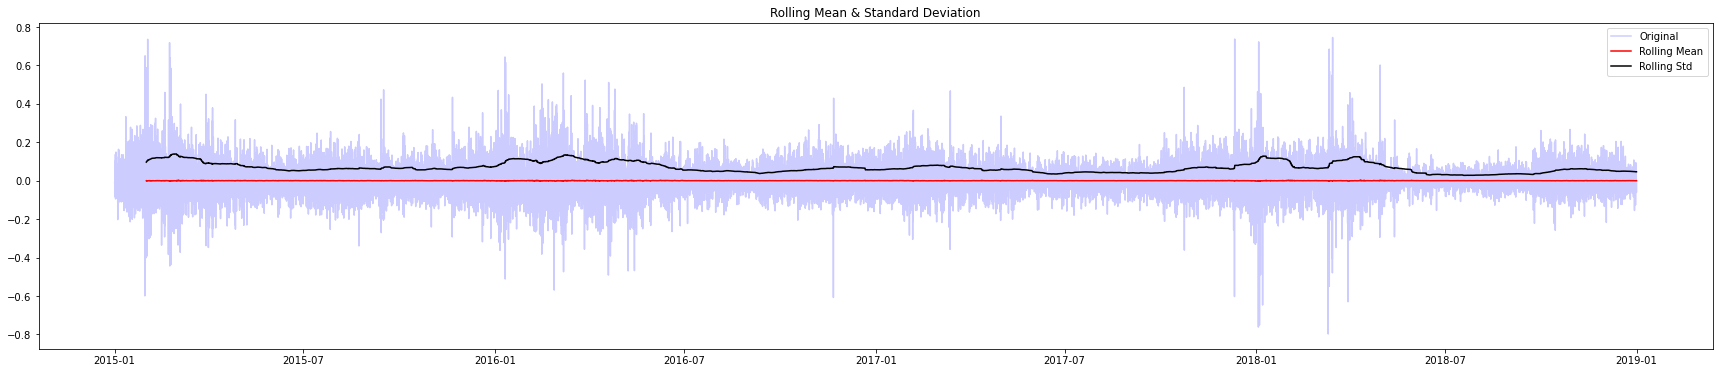

ADF Statistic: -31.96152421975659
p-value: 0.0
Critical Values:
	1%: -3.4305368188191343
	5%: -2.8616225693019306
	10%: -2.5668139490442607


In [9]:
final_log_shift = final_log - final_log.shift()
final_log_shift.dropna(inplace=True)
get_stationarity(final_log_shift)

Split the dataset :

In [98]:
df = final_log_shift.copy()
df_train = df['2015-01-01':'2017-12-31']
df_test = df['2018-01-01':]
df

datetime
2015-01-01 01:00:00   -0.007519
2015-01-01 02:00:00   -0.006801
2015-01-01 03:00:00   -0.083409
2015-01-01 04:00:00   -0.056881
2015-01-01 05:00:00   -0.043957
                         ...   
2018-12-31 19:00:00   -0.007631
2018-12-31 20:00:00   -0.011229
2018-12-31 21:00:00   -0.024725
2018-12-31 22:00:00   -0.061188
2018-12-31 23:00:00   -0.000143
Name: price actual, Length: 35059, dtype: float64

In [11]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.0


C:\Users\halim\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


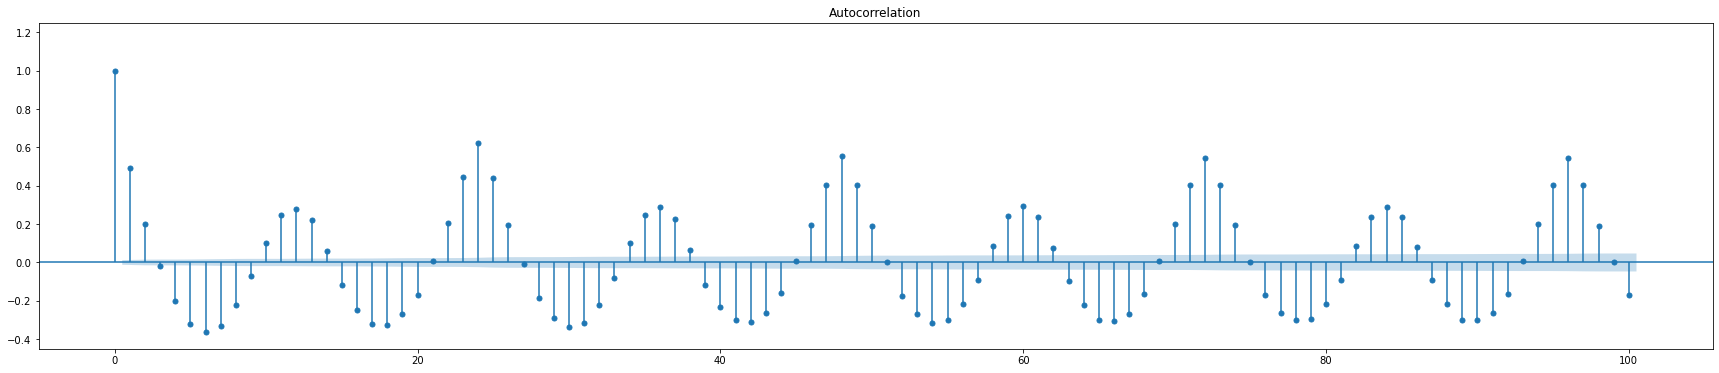

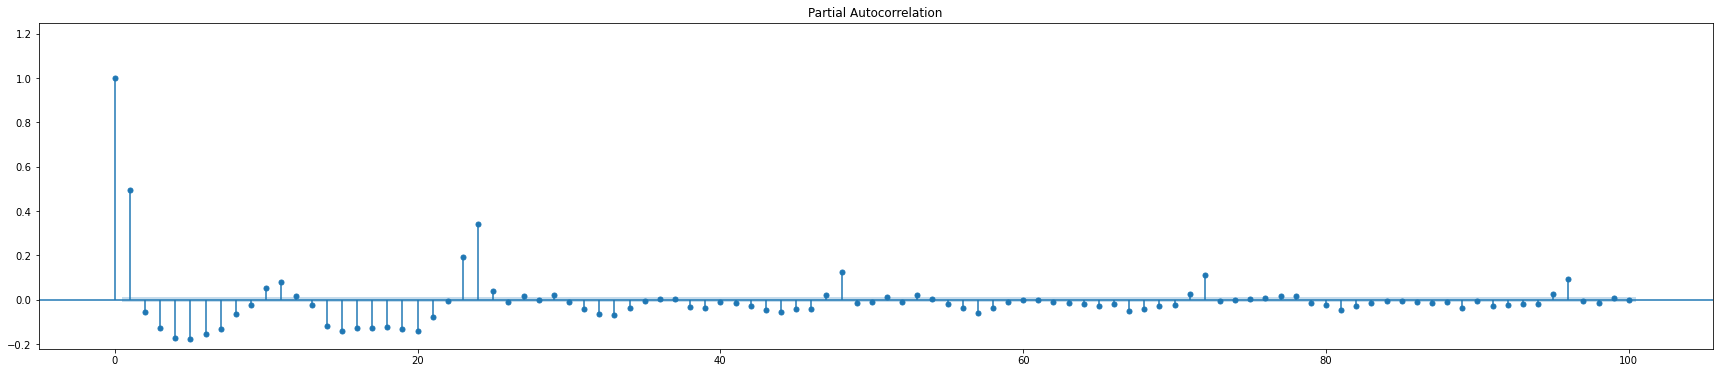

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(30,6))
acf_original = plot_acf(df_train,lags=100, ax=ax, auto_ylims=True)

fig, ax = plt.subplots(figsize=(30,6))
pacf_original = plot_pacf(df_train,lags=100, ax=ax, auto_ylims=True)

Both the ACF and PACF start with a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

The blue area (zoom to see) depicts the 95% confidence interval and is an indicator of the *significiance threshold*. Which means, anything within the blue aera is statisically close to zero and anything outside is statistically non-zero.

### Auto-regressive model

In [13]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(df_train, lags = 1).fit()
ar_model.summary()

C:\Users\halim\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:           price actual   No. Observations:                26300
Model:                     AutoReg(1)   Log Likelihood               34769.168
Method:               Conditional MLE   S.D. of innovations              0.065
Date:                Sat, 26 Nov 2022   AIC                         -69532.336
Time:                        18:06:29   BIC                         -69507.804
Sample:                             1   HQIC                        -69524.415
                                26300                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.897e-05      0.000     -0.048      0.962      -0.001       0.001
price actual.L1     0.4939      0.005     92.105      0.000       0.483       0.504
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0249           +0.0000j            2.0249            0.0000
-----------------------------------------------------------------------------
"""

In [14]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(df_train, lags = 2).fit()
ar_model.summary()

C:\Users\halim\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:           price actual   No. Observations:                26300
Model:                     AutoReg(2)   Log Likelihood               34808.119
Method:               Conditional MLE   S.D. of innovations              0.064
Date:                Sat, 26 Nov 2022   AIC                         -69608.239
Time:                        18:06:29   BIC                         -69575.530
Sample:                             2   HQIC                        -69597.677
                                26300                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.926e-05      0.000     -0.049      0.961      -0.001       0.001
price actual.L1     0.5214      0.006     84.667      0.000       0.509       0.533
price actual.L2    -0.0557      0.006     -9.037      0.000      -0.068      -0.044
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.6917           +0.0000j            2.6917            0.0000
AR.2            6.6737           +0.0000j            6.6737            0.0000
-----------------------------------------------------------------------------
"""

### Prediction

model = ARIMA(df_train, order=(p,q,d) where

    p is the order of the AR term 
        (# of lags of Y to be utilized as predictors) --> 1 here as lag 1 is quite significant
    q is the order of the MA term
        (# of lagged forecast errors should be used)
    d is the number of differences required to make the time series stationary --> 2 here

In [15]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(2,1,2))
model_fit = model.fit()

model_fit.summary()

C:\Users\halim\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\halim\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\halim\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           price actual   No. Observations:                26300
Model:                 ARIMA(2, 1, 0)   Log Likelihood               31723.070
Date:                Sat, 26 Nov 2022   AIC                         -63440.140
Time:                        18:06:30   BIC                         -63415.608
Sample:                             0   HQIC                        -63432.219
                              - 26300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2369      0.003    -72.408      0.000      -0.243      -0.230
ar.L2         -0.1193      0.004    -31.923      0.000      -0.127      -0.112
sigma2         0.0052   2.19e-05    239.042      0.000       0.005       0.005
===================================================================================
Ljung-Box (L1) (Q):                   2.91   Jarque-Bera (JB):             52417.31
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

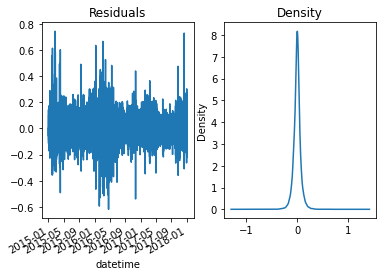

In [16]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()